In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from skimage import io, exposure, transform
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import random
import cv2
import os

In [36]:
class TrafficSignNet(nn.Module):
    def __init__(self, width, height, depth, classes):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=depth, out_channels = 8, 
                               kernel_size = 5, padding = 2)
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, 
                               kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, 
                               kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32,
                               kernel_size=3, padding = 1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=3, padding = 1)
        self.bn5 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * (height // 8) * (width // 8), 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, classes)

        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = torch.flatten(x, 1)

        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn7(self.fc2(x)))
        x = self.dropout(x)

        x = self.fc3(x)

        return F.log_softmax(x, dim=1)
    


In [37]:
class TrafficDataLoader(Dataset):
    def __init__(self, base_path, csv_path):
        self.data = []
        self.labels = []
        with open(csv_path, 'r') as f:
            rows = f.read().strip().split("\n")[1:]
            random.shuffle(rows)
            for row in rows:
                label, image_path = row.strip().split(",")[-2:]
                image_path = os.path.join(base_path, image_path)
                image = io.imread(image_path)
                image = transform.resize(image, (32, 32))
                image = exposure.equalize_adapthist(image, clip_limit=0.1)
                self.data.append(image)
                self.labels.append(int(label))

        self.data = np.array(self.data, dtype="float32") / 255.0
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx].transpose((2,0,1)), dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label


In [64]:

args = {"dataset": "data/GTSRB/",
        "model":"output/trafficsignnet.pth",
        "accPlot":"output/acc.png",
        "lossPlot":"output/loss.png",
        "lAPlot":"output/loss_acc.png"}

In [39]:
train_path = os.path.join(args["dataset"], "Train.csv")
test_path = os.path.join(args["dataset"], "Test.csv")

train_dataset = TrafficDataLoader(args["dataset"], train_path)
test_dataset = TrafficDataLoader(args["dataset"], test_path)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = TrafficSignNet(width=32, height=32, 
                       depth = 3, classes = len(np.unique(train_dataset.labels)))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [40]:
train_losses = []
train_accuracies = []

def train(epoch):
    model.train()
    correct_train = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1)
        correct_train += pred.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct_train / len(train_loader.dataset))

In [41]:
val_losses = []
val_accuracies = []

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim = 1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accuracies.append(100. * correct / len(test_loader.dataset))
    
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}({100. * correct / len(test_loader.dataset):.2f}%)\n")

In [42]:
num_epochs = 30
for epoch in range(0, num_epochs + 1):
    train(epoch)
    test()

torch.save(model.state_dict(), args["model"])

Train Epoch: 0 [0/39209] Loss: 3.881238
Train Epoch: 0 [6400/39209] Loss: 2.368557
Train Epoch: 0 [12800/39209] Loss: 1.566932
Train Epoch: 0 [19200/39209] Loss: 1.258541
Train Epoch: 0 [25600/39209] Loss: 0.955382
Train Epoch: 0 [32000/39209] Loss: 0.915118
Train Epoch: 0 [38400/39209] Loss: 0.677738

Test set: Average loss: 0.0609, Accuracy: 1889/12630(14.96%)

Train Epoch: 1 [0/39209] Loss: 0.574164
Train Epoch: 1 [6400/39209] Loss: 0.535817
Train Epoch: 1 [12800/39209] Loss: 0.461260
Train Epoch: 1 [19200/39209] Loss: 0.531952
Train Epoch: 1 [25600/39209] Loss: 0.477707
Train Epoch: 1 [32000/39209] Loss: 0.430652
Train Epoch: 1 [38400/39209] Loss: 0.315733

Test set: Average loss: 0.0436, Accuracy: 3972/12630(31.45%)

Train Epoch: 2 [0/39209] Loss: 0.227326
Train Epoch: 2 [6400/39209] Loss: 0.333662
Train Epoch: 2 [12800/39209] Loss: 0.184829
Train Epoch: 2 [19200/39209] Loss: 0.343764
Train Epoch: 2 [25600/39209] Loss: 0.193938
Train Epoch: 2 [32000/39209] Loss: 0.233772
Train Epo

In [43]:
test_preds = []
test_targets = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        preds = output.argmax(dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_targets.extend(target.numpy())

print(classification_report(test_targets, test_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.94      0.99      0.96       720
           2       0.95      0.98      0.97       750
           3       0.99      0.91      0.94       450
           4       0.98      0.98      0.98       660
           5       0.90      0.93      0.91       630
           6       0.97      0.85      0.91       150
           7       0.93      0.98      0.95       450
           8       0.99      0.94      0.97       450
           9       0.93      1.00      0.96       480
          10       0.98      0.98      0.98       660
          11       0.92      0.92      0.92       420
          12       0.96      0.97      0.96       690
          13       0.97      1.00      0.98       720
          14       0.99      0.98      0.99       270
          15       1.00      0.96      0.98       210
          16       0.99      0.96      0.97       150
          17       0.98    

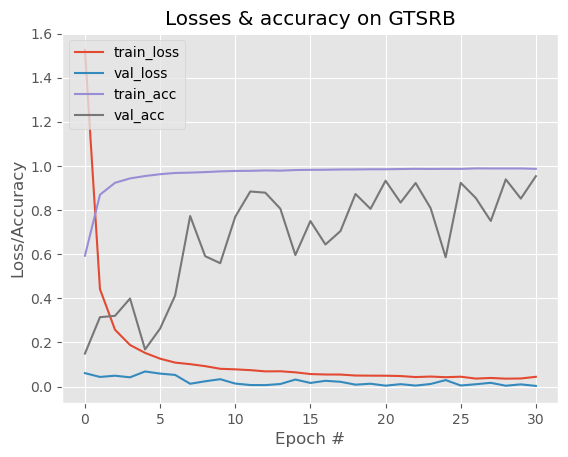

In [76]:
N = np.arange(0, num_epochs + 1)
plt.style.use('ggplot')
plt.figure()
ta = [x/100 for x in train_accuracies]
va = [x/100 for x in val_accuracies]
plt.plot(N, train_losses, label="train_loss")
plt.plot(N, val_losses, label="val_loss")
plt.plot(N, ta, label="train_acc")
plt.plot(N, va, label="val_acc")

plt.title("Losses & accuracy on GTSRB")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig(args["lAPlot"])

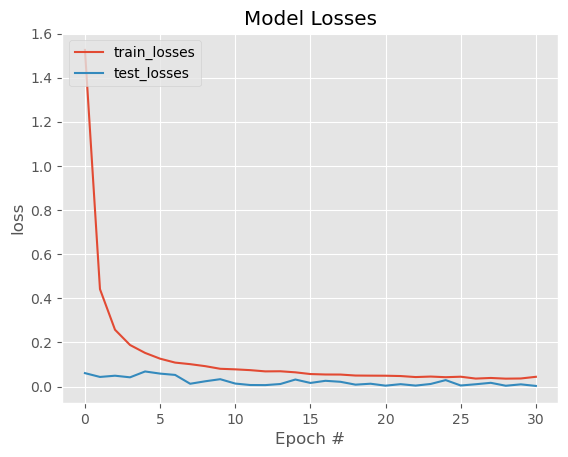

In [59]:
N = np.arange(0, num_epochs + 1)
plt.figure()

plt.plot(N, train_losses, label="train_losses")
plt.plot(N, val_losses, label="test_losses")

plt.title("Model Losses")
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend(loc="upper left")
plt.savefig(args["lossPlot"])


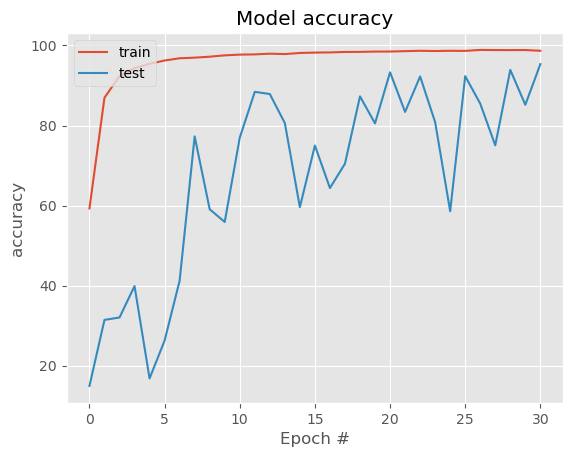

In [60]:
N = np.arange(0, num_epochs + 1)
plt.figure()

plt.plot(N, train_accuracies, label="train")
plt.plot(N, val_accuracies, label="test")

plt.title("Model accuracy")
plt.xlabel("Epoch #")
plt.ylabel("accuracy")
plt.legend(loc="upper left")
plt.savefig(args["accPlot"])


In [79]:
pred_args = {"model":"output/trafficsignnet.model",
        "images":"data/GTSRB/Test",
        "pred":"output/preds/"}

In [82]:
print("[INFO] Loading model...")
model = TrafficSignNet(width=32, height=32, 
                       depth = 3, classes = len(np.unique(train_dataset.labels)))
model.load_state_dict(torch.load(pred_args["model"]))

labelNames = open("data/signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]
print(labelNames)

[INFO] Loading model...
['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3

In [86]:
print("[INFO] predicting...")
imagePaths = list(paths.list_images(pred_args["images"]))
random.shuffle(imagePaths)
imagePaths = imagePaths[:25]

for i, imagePath in enumerate(imagePaths):
    image = io.imread(imagePath)
    image = transform.resize(image, (32, 32))
    image = exposure.equalize_adapthist(image, clip_limit=0.1)
    image = image.astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    image = torch.from_numpy(image)
    image = image.unsqueeze(0)

    model.eval()
    with torch.no_grad():
        preds = model(image)
    
    j = np.argmax(preds.numpy(), axis=1)[0]
    label = labelNames[j]

    image = cv2.imread(imagePath)
    image = cv2.resize(image, (128, 128))
    cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX,
                0.45, (0, 0, 255), 2)
    
    p = os.path.sep.join(["output/preds/", "{}.png".format(i)])
    cv2.imwrite(p, image)


[INFO] predicting...
